In [2]:
import numpy as np
import pandas as pd
import sys
import ast
from pathlib import Path

parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

from utils.load import load_sequences, load_metadata
from utils.pitch import extract_pitch_based_features
from models.cluster import KMeansClusterModel
from sklearn.preprocessing import StandardScaler

this notebook follows the approach of [the national anthem paper](https://arxiv.org/html/2404.03606v1#bib.bib2). 


approach is:
- extract the pictches from the data
- extract ratings from meta data
- cluster them using K-means clustering into two clusters
- find their similiarity

conclusion
- it classifies the majority of the pitches as high pitches
- classifies the ratings bad/good 50% on each
- it is not possible to say anything about it movies with low pitches have lower ratings or vice versa


In [3]:
def extract_all_features(max_interval=12):
    """Extract pitch-based features from all sequences and return a dataframe."""

    sequences_df = load_sequences("../data/sequences")
    records = []

    for idx, row in sequences_df.iterrows():
        seq = row["sequence"]
        features = extract_pitch_based_features(seq, max_interval=max_interval)

        if np.any(np.isnan(features)):
            continue  # skip bad sequences

        records.append({
            "id": idx,
            "features": np.array(features, dtype=float),
            "path": row["path"]
        })

    df = pd.DataFrame(records, index=[r["id"] for r in records]).sort_index()
    return df

In [4]:
def get_normalized_imdb(ratings_str):
    """Extract the normalized IMDb rating from the ratings string."""
    try:
        ratings = ast.literal_eval(ratings_str)
        imdb_value = next(r['Value'] for r in ratings if r['Source'] == 'Internet Movie Database')
        num, denom = imdb_value.split("/")
        return float(num) / float(denom)
    except (StopIteration, ValueError, TypeError):
        return None  # If IMDb rating not found or ratings are malformed


In [5]:
metadata_df = load_metadata("../data/metadata/movies_metadata.csv")
metadata_df['imdb_normalized'] = metadata_df['ratings'].apply(get_normalized_imdb)
median_imdb = metadata_df['imdb_normalized'].median()
metadata_df['rating_disc'] = np.where(metadata_df['imdb_normalized'] <= median_imdb, 'low', 'high')
metadata_df = metadata_df[['imdb_normalized', 'rating_disc']]
metadata_df = metadata_df.reset_index()

In [6]:
features_df = extract_all_features()
features_df['mean_pitch'] = features_df['features'].apply(np.mean)
median_pitch = features_df['mean_pitch'].median()
features_df['pitch_disc'] = np.where(features_df['mean_pitch'] < median_pitch, 'low', 'high')

2025-11-25 12:45:25.279 | INFO     | utils.load:load_sequences:59 - Loading sequences from ../data/sequences with extension .npy
Loading sequences: 91it [00:00, 3726.16it/s]
2025-11-25 12:45:25.310 | SUCCESS  | utils.load:load_sequences:81 - Loaded 91 sequences from ../data/sequences
/Users/karlfindhansen/Desktop/DTU/Kandidat/4. Semester/Comp tools/project-02807/utils/pitch.py:33: RuntimeWarning: invalid value encountered in log1p
  return np.log1p(M)


In [7]:
features_df

,id,features,path,mean_pitch,pitch_disc
tt0026138,tt0026138,"[0.15641568645811044, 0.0, 0.04652001563489285...",../data/sequences/tt0026138_seq.npy,0.069134,high
tt0029583,tt0029583,"[0.08338160893905106, 0.0, 0.16034265007517937...",../data/sequences/tt0029583_seq.npy,0.047549,low
tt0032138,tt0032138,"[0.10919929196499199, 0.0, 0.08594242980072472...",../data/sequences/tt0032138_seq.npy,0.067703,low
tt0040076,tt0040076,"[0.2394753224005805, 0.033081268883245904, 0.0...",../data/sequences/tt0040076_seq.npy,0.071839,high
tt0045152,tt0045152,"[0.20731756268375384, 0.0012861738107441613, 0...",../data/sequences/tt0045152_seq.npy,0.071334,high
...,...,...,...,...,...
tt0372824,tt0372824,"[0.0, 2.490018997e-314, 0.0, 2.4900183647e-314...",../data/sequences/tt0372824_seq.npy,0.048076,low
tt0418279,tt0418279,"[0.20067069546215116, 0.0, 0.1053605156578263,...",../data/sequences/tt0418279_seq.npy,0.041536,low
tt0499549,tt0499549,"[0.0, 0.0, 0.0, 0.6931471805599453, 0.0, 0.0, ...",../data/sequences/tt0499549_seq.npy,0.195215,high
tt0988045,tt0988045,"[0.0, 1.097e-321, 0.0, 1.097e-321, 2.67e-322, ...",../data/sequences/tt0988045_seq.npy,0.048173,low


In [8]:
df = features_df.merge(metadata_df[['id', 'imdb_normalized', 'rating_disc']], on='id')
df = df[['id','features', 'imdb_normalized']]

In [9]:
df

,id,features,imdb_normalized
0,tt0026138,"[0.15641568645811044, 0.0, 0.04652001563489285...",0.78
1,tt0029583,"[0.08338160893905106, 0.0, 0.16034265007517937...",0.76
2,tt0032138,"[0.10919929196499199, 0.0, 0.08594242980072472...",0.81
3,tt0040076,"[0.2394753224005805, 0.033081268883245904, 0.0...",0.70
4,tt0045152,"[0.20731756268375384, 0.0012861738107441613, 0...",0.83
...,...,...,...
84,tt0372824,"[0.0, 2.490018997e-314, 0.0, 2.4900183647e-314...",0.78
85,tt0418279,"[0.20067069546215116, 0.0, 0.1053605156578263,...",0.71
86,tt0499549,"[0.0, 0.0, 0.0, 0.6931471805599453, 0.0, 0.0, ...",0.79
87,tt0988045,"[0.0, 1.097e-321, 0.0, 1.097e-321, 2.67e-322, ...",0.75


In [ ]:
X_features = np.stack(df['features'].to_numpy())
X_score = df['imdb_normalized'].to_numpy().reshape(-1, 1)  

scaler_features = StandardScaler()
X_features_scaled = scaler_features.fit_transform(X_features)

scaler_score = StandardScaler()
X_score_scaled = scaler_score.fit_transform(X_score)

In [12]:
n_clusters = 2

# Cluster pitches
kmeans_features = KMeansClusterModel(n_clusters=n_clusters, max_iters=100, tol=1e-4, random_state=42)
kmeans_features.fit(X_features_scaled)
feature_labels = kmeans_features.labels_

# Cluster scores
kmeans_score = KMeansClusterModel(n_clusters=n_clusters, max_iters=100, tol=1e-4, random_state=42)
kmeans_score.fit(X_score_scaled)
score_labels = kmeans_score.labels_

df = pd.DataFrame()
df['id'] = features_df['id']
df['score_labels'] = score_labels
df['pitches_labels'] = feature_labels

In [13]:
def calculate_cluster_similarity_manual(df: pd.DataFrame, clusters: int, ind_clusters: int):

    similarity_data = []
    
    for i in range(clusters):
        cluster1 = df[df['pitches_labels'] == i]
    
        if cluster1.empty:
            continue
            
        for j in range(ind_clusters):
            cluster2 = df[df['score_labels'] == j]
            
            if cluster2.empty:
                continue
                
            id1 = set(cluster1['id'].values)
            id2 = set(cluster2['id'].values)
            
            intersection_size = len(id1.intersection(id2))
            
            min_size = min(len(id1), len(id2))
            
            if min_size == 0:
                sim = 0.0
            else:
                sim = intersection_size / min_size
            
            similarity_data.append([f"Cluster {i}", f"Cluster {j}", sim])
            
            # Print the required output format
            print(f"Similarity between cluster {i} of songs and cluster {j} of Index: {sim*100:.2f}%")
            
    return similarity_data

similarity_results = calculate_cluster_similarity_manual(df, 2, 2)

Similarity between cluster 0 of songs and cluster 0 of Index: 50.00%
Similarity between cluster 0 of songs and cluster 1 of Index: 50.00%
Similarity between cluster 1 of songs and cluster 0 of Index: 95.00%
Similarity between cluster 1 of songs and cluster 1 of Index: 95.92%


In [14]:
print("low pitch", len(feature_labels[feature_labels == 0]))
print("high pitch", len(feature_labels[feature_labels == 1]))

print("low score", len(score_labels[score_labels == 0]))
print("high pitch", len(score_labels[score_labels == 1]))

low pitch 4
high pitch 85
low score 40
high pitch 49


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='Index Cluster', ylabel='id'>

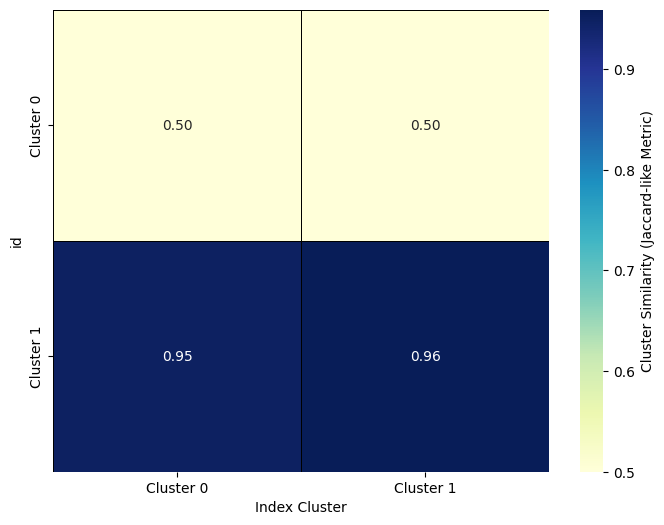

In [16]:
similarity_df = pd.DataFrame(similarity_results, columns=['id', 'Index Cluster', 'Similarity'])
heatmap_data = similarity_df.pivot(
    index='id', 
    columns='Index Cluster', 
    values='Similarity'
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data, 
    annot=True,             
    fmt=".2f",               
    cmap="YlGnBu",          
    linewidths=.5,          
    linecolor='black',       
    cbar_kws={'label': 'Cluster Similarity (Jaccard-like Metric)'}
)